In [440]:
import sys, importlib
from pathlib import Path

# Core data analysis imports
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import gaussian_kde

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Setup imports
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Force reload all modules
modules = ['iowa_dream.data', 'iowa_dream.data.load_data', 
          'iowa_dream.data.cleaner', 'iowa_dream.data.sample_split']

for m in modules:
    if m in sys.modules:
        importlib.reload(sys.modules[m])
    else:
        __import__(m)

from iowa_dream.data.load_data import load_config
from iowa_dream.data.cleaner import preliminary_load_and_clean_data 
from iowa_dream.data.sample_split import create_sample_split


In [572]:
# Example usage
data_file = project_root / load_config()['kaggle']['download_path'] / 'AmesHousing.csv'
df = preliminary_load_and_clean_data(data_file)

In [573]:
# Check if PID column contains unique IDs
print(f"Total number of rows: {len(df)}")
print(f"Number of unique PIDs: {df['pid'].nunique()}")
print(f"Are all PIDs unique? {df['pid'].is_unique}")

Total number of rows: 2930
Number of unique PIDs: 2930
Are all PIDs unique? True


In [574]:
# Check for duplicate rows across all columns
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()

print(f"\nNumber of completely duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(df[duplicate_rows])

# Check specifically for rows with same values but different PIDs/Order
print("\nChecking for duplicates excluding PID and Order columns:")
duplicate_content = df.drop(['pid', 'order'], axis=1).duplicated()
num_content_duplicates = duplicate_content.sum()

print(f"Number of rows with identical values (excluding PID/Order): {num_content_duplicates}")

if num_content_duplicates > 0:
    content_duplicate_indices = df[duplicate_content].index
    print("\nRows with identical values (showing with PID/Order):")
    print(df.loc[content_duplicate_indices])




Number of completely duplicate rows: 0

Checking for duplicates excluding PID and Order columns:
Number of rows with identical values (excluding PID/Order): 0


In [575]:
# Analyze all columns: missing data, data types, and value distributions
total = df.isnull().sum()
percent = (df.isnull().sum()/df.isnull().count())
dtypes = df.dtypes
is_categorical = df.dtypes.apply(lambda x: 'categorical' if x == 'object' else 'numerical')

# Get unique values for categorical and ranges for numerical
def get_value_info(col):
    if df[col].dtype == 'object':
        unique_vals = sorted(df[col].dropna().unique())
        return f"{len(unique_vals)} unique values: {', '.join(map(str, unique_vals))}"
    else:
        val_range = df[col].max() - df[col].min()
        unique_count = len(df[col].unique())
        # Add note if numerical column might be categorical
        categorical_hint = " (Possible categorical: few unique values)" if unique_count < 15 else ""
        return f"Range: {df[col].min():.2f} to {df[col].max():.2f} ({unique_count} unique values){categorical_hint}"

value_info = {col: get_value_info(col) for col in df.columns}

# Identify numerical columns with too few unique values
numerical_maybe_categorical = [col for col in df.columns if df[col].dtype != 'object' and len(df[col].unique()) < 30]

# Identify float columns that should be integers
float_should_be_int = [col for col in df.select_dtypes(include=['float']).columns if (df[col].dropna() % 1 == 0).all()]

# Create comprehensive DataFrame with all column information
column_analysis = pd.concat([
    total, 
    percent, 
    dtypes,
    is_categorical,
    pd.Series(value_info)
], axis=1, keys=['Total Missing', 'Percent Missing', 'Data Type', 'Variable Type', 'Value Information'])

# Sort by percent missing for better overview and display full table
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap long strings
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

print("Complete Column Analysis (sorted by missing values):")
display(column_analysis.sort_values('Percent Missing', ascending=False))

# Additional summary
print("\nSummary:")
print(f"Total columns: {len(df.columns)}")
print(f"Categorical columns: {(is_categorical == 'categorical').sum()}")
print(f"Numerical columns: {(is_categorical == 'numerical').sum()}")
print(f"Columns with missing values: {(total > 0).sum()}")
print(f"Numerical columns with too few unique values (should be categorical maybe): {numerical_maybe_categorical}")
print(f"Float columns that should be integers: {float_should_be_int}")
print(f"All float columns should be integers: {len(float_should_be_int) == len(df.select_dtypes(include=['float']).columns)}")

Complete Column Analysis (sorted by missing values):


,Total Missing,Percent Missing,Data Type,Variable Type,Value Information
pool_qc,2917,0.995563,object,categorical,"4 unique values: Ex, Fa, Gd, TA"
misc_feature,2824,0.963823,object,categorical,"5 unique values: Elev, Gar2, Othr, Shed, TenC"
alley,2732,0.932423,object,categorical,"2 unique values: Grvl, Pave"
fence,2358,0.804778,object,categorical,"4 unique values: GdPrv, GdWo, MnPrv, MnWw"
mas_vnr_type,1775,0.605802,object,categorical,"4 unique values: BrkCmn, BrkFace, CBlock, Stone"
fireplace_qu,1422,0.485324,object,categorical,"5 unique values: Ex, Fa, Gd, Po, TA"
lot_frontage,490,0.167235,float64,numerical,Range: 21.00 to 313.00 (129 unique values)
garage_cond,159,0.054266,object,categorical,"5 unique values: Ex, Fa, Gd, Po, TA"
garage_finish,159,0.054266,object,categorical,"3 unique values: Fin, RFn, Unf"
garage_yr_blt,159,0.054266,float64,numerical,Range: 1895.00 to 2207.00 (104 unique values)



Summary:
Total columns: 82
Categorical columns: 43
Numerical columns: 39
Columns with missing values: 27
Numerical columns with too few unique values (should be categorical maybe): ['ms_subclass', 'overall_qual', 'overall_cond', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_cars', 'pool_area', 'mo_sold', 'yr_sold']
Float columns that should be integers: ['lot_frontage', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_yr_blt', 'garage_cars', 'garage_area']
All float columns should be integers: True


Therefore, firstly the cleaning function should standardise the value of all floats to integers. 

# Missing values that can directly be filled from data dictionary information 

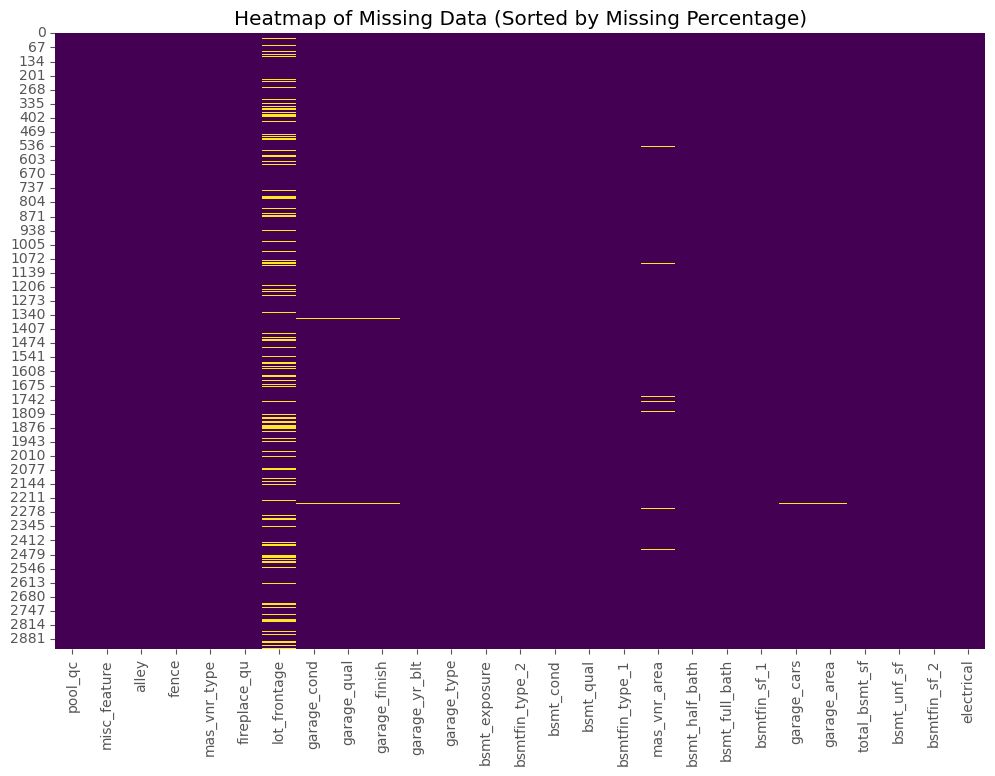

In [598]:
# Filter columns with missing values and sort by the percentage of missing values
missing_columns = column_analysis[column_analysis['Total Missing'] > 0].sort_values('Percent Missing', ascending=False).index

# Visualize missing data by a heatmap, with sorted columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[missing_columns].isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (Sorted by Missing Percentage)')
plt.xticks(ticks=np.arange(len(missing_columns)) + 0.5, labels=missing_columns, rotation=90, ha='center')  # Adjust x-axis labels
plt.show()

Firstly, from the data dictionary, we know that 'NA' would imply NoPool.  

In [577]:
# Check relationship between pool_area and pool_qc
print("Checking pool_area and pool_qc relationship:")

# Check if all pool_area == 0 implies pool_qc is NA
zero_pool_area = df['pool_area'] == 0
na_pool_qc = df['pool_qc'].isna()

print("\nAll pool_area == 0 implies pool_qc is NA?")
print(f"Total rows with pool_area == 0: {zero_pool_area.sum()}")
print(f"Of these, number with pool_qc == NA: {(zero_pool_area & na_pool_qc).sum()}")
print(f"Percentage match: {(zero_pool_area & na_pool_qc).sum() / zero_pool_area.sum() * 100:.2f}%")

# Check if all pool_qc is NA implies pool_area == 0
print("\nAll pool_qc == NA implies pool_area == 0?") 
print(f"Total rows with pool_qc == NA: {na_pool_qc.sum()}")
print(f"Of these, number with pool_area == 0: {(na_pool_qc & zero_pool_area).sum()}")
print(f"Percentage match: {(na_pool_qc & zero_pool_area).sum() / na_pool_qc.sum() * 100:.2f}%")

Checking pool_area and pool_qc relationship:

All pool_area == 0 implies pool_qc is NA?
Total rows with pool_area == 0: 2917
Of these, number with pool_qc == NA: 2917
Percentage match: 100.00%

All pool_qc == NA implies pool_area == 0?
Total rows with pool_qc == NA: 2917
Of these, number with pool_area == 0: 2917
Percentage match: 100.00%


Similarly, we can see that for all the bsmt variables, the missing values are represented by 'NA', which means no basement. Similarly, for fence, garages, fireplaces, and alley (for alley access). Furthermore, misc_feature NA indicates that no miscellaneous features are present to affect price.

In [597]:
def fill_missing_by_keywords(df, keywords):
    """
    Fill missing values in columns containing any of the given keywords.
    For categorical columns, fills with 'NA'.
    For numeric columns, fills with 0.
    
    Args:
        df: pandas DataFrame
        keywords: list of strings to match in column names
    Returns:
        DataFrame with filled missing values
    """
    # Make a copy to avoid modifying original
    df_filled = df.copy()
    
    # Get columns containing any of the keywords
    cols_to_fill = []
    for keyword in keywords:
        cols_to_fill.extend([col for col in df.columns if keyword.lower() in col.lower()])
    cols_to_fill = list(set(cols_to_fill))  # Remove duplicates
    
    for col in cols_to_fill:
        # Fill based on data type
        if df[col].dtype == 'object':
            df_filled[col] = df[col].fillna('NA')
        else:
            df_filled[col] = df[col].fillna(0)
            
    return df_filled

# Example usage for pool, garage, basement etc
df = fill_missing_by_keywords(df, ['pool', 'bsmt', 'fireplace', 'fence', 'alley', 'misc_feature'])


In [579]:
# Check for any columns with "yr" or "year" in the name that have values larger than the current year
year_columns = [col for col in df.columns if 'yr' in col.lower() or 'year' in col.lower()]
final_year = 2010

for col in year_columns:
    if (df[col] > final_year).any():
        print(f"Column '{col}' has values larger than {final_year}:")
        print(df[df[col] > final_year][[col]].drop_duplicates())

Column 'garage_yr_blt' has values larger than 2010:
      garage_yr_blt
2260         2207.0


In [580]:
# Fix typo in garage_yr_blt where 2207 is likely meant to be 2007
df.loc[df['garage_yr_blt'] == 2207, 'garage_yr_blt'] = 2007

In [581]:
# Check if any 'year_built' or 'garage_yr_blt' is larger than 'yr_sold'
if (df['year_built'] > df['yr_sold']).any():
    print("There are records where 'year_built' is larger than 'yr_sold':")
    print(df[df['year_built'] > df['yr_sold']][['year_built', 'yr_sold']])

if (df['garage_yr_blt'] > df['yr_sold']).any():
    print("There are records where 'garage_yr_blt' is larger than 'yr_sold':")
    print(df[df['garage_yr_blt'] > df['yr_sold']][['garage_yr_blt', 'yr_sold']])



There are records where 'year_built' is larger than 'yr_sold':
      year_built  yr_sold
2180        2008     2007
There are records where 'garage_yr_blt' is larger than 'yr_sold':
      garage_yr_blt  yr_sold
2180         2008.0     2007


In [582]:
# Only one value being sold before it is built, this may be useful, so we keep it as this way.
df.loc[2180].to_frame().T

,order,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
2180,2181,908154195,20,RL,128.0,39290,Pave,NA,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NA,NA,Elev,17000,10,2007,New,Partial,183850


In [583]:
# Check and display full rows with missing values for electrical and mas_vnr_area
df[df['electrical'].isnull()]

,order,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
1577,1578,916386080,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NA,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NA,NA,NaN,0,5,2008,WD,Normal,167500


In [584]:
# Check for the type similar properties in the area as they tend to have the same electrical type
df[(df['ms_subclass'] == 80) & (df['neighborhood'] == "Timber")].groupby(['street', 'year_built'])['electrical'].value_counts().unstack(fill_value=0)

electrical         SBrkr
street year_built       
Pave   1987            1
       1988            1
       2003            1
       2006            1

In [585]:
# Fill missing values in 'electrical' with 'SBrkr' because all houses there have the same kind of eletrical
df['electrical'] = df['electrical'].fillna('SBrkr')

In [586]:
df['mas_vnr_type'].unique()

array(['Stone', nan, 'BrkFace', 'BrkCmn', 'CBlock'], dtype=object)

In [587]:
# Print all rows where 'mas_vnr_area' is 0 and display 'mas_vnr_type'
mas_vnr_area_zero = df[df['mas_vnr_area'] == 0]
# Calculate and print the count of each 'mas_vnr_type' where 'mas_vnr_area' is 0, treating NaN as a distinct type
mas_vnr_type_count = mas_vnr_area_zero['mas_vnr_type'].fillna('NA').value_counts()
print(mas_vnr_type_count)

mas_vnr_type
NA         1745
BrkFace       2
Stone         1
Name: count, dtype: int64


There can be some issues with the recording of these three rows because those with mas_vnr_area == 0 should then technically have no relevant types. Hence, we will mark "NA" for type as non-applicable. 

In [588]:
# Replace 'mas_vnr_type' with 'NA' where 'mas_vnr_area' is 0
df.loc[df['mas_vnr_area'] == 0, 'mas_vnr_type'] = 'NA'


In [589]:
# Print all rows where either 'mas_vnr_area' or 'mas_vnr_type' are missing
missing_mas_vnr = df[df['mas_vnr_area'].isnull() | df['mas_vnr_type'].isnull()]
missing_mas_vnr[['mas_vnr_area', 'mas_vnr_type']]

,mas_vnr_area,mas_vnr_type
55,NaN,NaN
363,344.0,NaN
403,312.0,NaN
441,285.0,NaN
484,NaN,NaN
517,NaN,NaN
538,NaN,NaN
867,NaN,NaN
1095,NaN,NaN
1119,NaN,NaN


We then mark for another type 'Missing' for mas_vnr_type in this case and we will later think of a way of imputing area given train test split

In [590]:
# Replace remaining missing values in 'mas_vnr_type' with 'Missing'
df['mas_vnr_type'] = df['mas_vnr_type'].fillna('Missing')


In [591]:
# Check if 'garage_area' is missing when 'garage_cars' is missing and vice versa
missing_garage_area = df['garage_area'].isnull()
missing_garage_cars = df['garage_cars'].isnull()

if (missing_garage_area != missing_garage_cars).any():
    print("There are inconsistencies between missing 'garage_area' and 'garage_cars':")
    print(df[missing_garage_area != missing_garage_cars][['garage_area', 'garage_cars']])
else:
    print("No inconsistencies found between missing 'garage_area' and 'garage_cars'.")


No inconsistencies found between missing 'garage_area' and 'garage_cars'.


In [592]:
# Fill 'garage_finish', 'garage_cond', 'garage_type', 'garage_qual' with 'NA' if 'garage_area' is 0 or 'garage_cars' is 0
df.loc[(df['garage_area'] == 0) | (df['garage_cars'] == 0), ['garage_finish', 'garage_cond', 'garage_type', 'garage_qual']] = 'NA'


In [593]:
# Fill missing values in 'garage_yr_blt' with 'year_built'
df['garage_yr_blt'] = df['garage_yr_blt'].fillna(df['year_built'])


In [594]:
# Check for any columns with 'garage_cars' or 'garage_area' that are missing values
missing_garage_remained = df[df['garage_cars'].isnull() | df['garage_finish'].isnull()]
print(missing_garage_remained.filter(like='garage'))

     garage_type  garage_yr_blt garage_finish  garage_cars  garage_area  \
1356      Detchd         1910.0           NaN          1.0        360.0   
2236      Detchd         1923.0           NaN          NaN          NaN   

     garage_qual garage_cond  
1356         NaN         NaN  
2236         NaN         NaN  


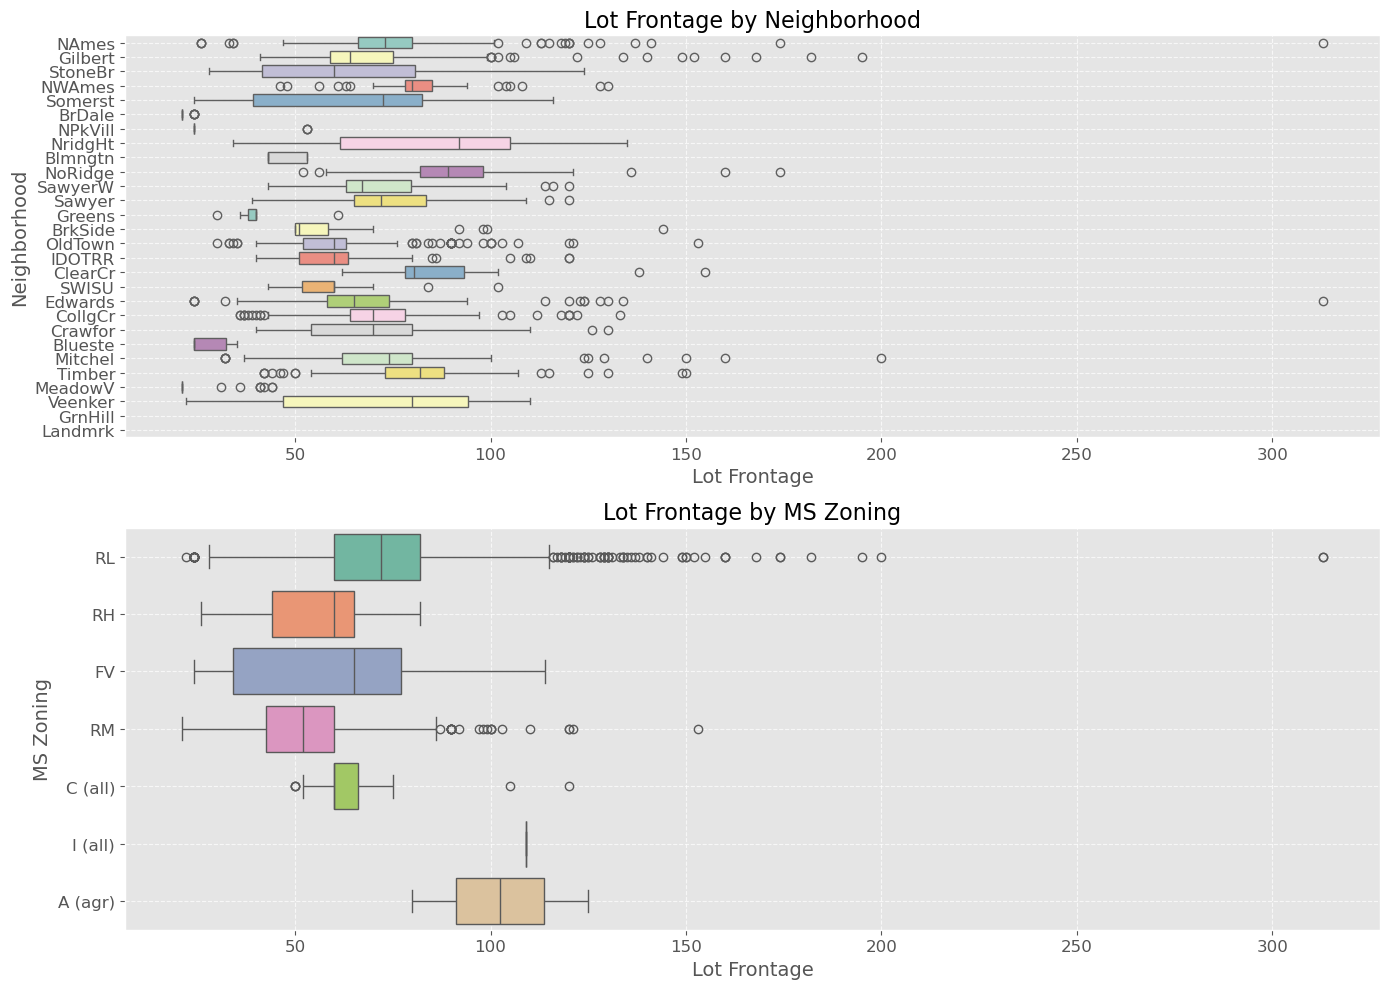

In [613]:
# Improved Plot Lot Frontage by Neighborhood and MS Zoning
plt.figure(figsize=(14, 10))

# Plot by Neighborhood
plt.subplot(2, 1, 1)
sns.boxplot(data=df, x='lot_frontage', y='neighborhood', hue='neighborhood', palette='Set3', dodge=False)
plt.title('Lot Frontage by Neighborhood', fontsize=16)
plt.xlabel('Lot Frontage', fontsize=14)
plt.ylabel('Neighborhood', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend([],[], frameon=False)  # Remove legend

# Plot by MS Zoning
plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='lot_frontage', y='ms_zoning', hue='ms_zoning', palette='Set2', dodge=False)
plt.title('Lot Frontage by MS Zoning', fontsize=16)
plt.xlabel('Lot Frontage', fontsize=14)
plt.ylabel('MS Zoning', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend([],[], frameon=False)  # Remove legend

plt.tight_layout()
plt.show()


# Correct the data format

### Feature Classification

#### Building Class:
- **`ms_subclass`**: Represents the class of the building and serves as a categorical variable.

#### Quality and Condition Rankings:
- **`overall_qual`**: Overall quality of the house.
- **`overall_cond`**: Overall condition of the house.

#### Bathroom Counts:
- **`bsmt_full_bath`**, **`bsmt_half_bath`**, **`full_bath`**, **`half_bath`**: Indicate the number of bathrooms. A higher number generally suggests a higher property value.

#### Room Counts:
- **`bedroom_abv_gr`**: Number of bedrooms above grade.
- **`kitchen_abv_gr`**: Number of kitchens above grade.
- **`totrms_abvgrd`**: Total rooms above grade (excluding bathrooms).
- **`fireplaces`**: Number of fireplaces. More rooms or features often correlate with higher value.

#### Other Discrete Features:
- **`garage_cars`**: Garage capacity (5 unique values).
- **`pool_area`**: Most are zero (maybe just no pools or there can be some problems with the data recording). Only 13 houses have positive pool size. Looking into this online, it seems like the data may actually miss information about the pool, and record 0 for all houses in such cases, some of they may still have pools actually.
- **`mo_sold`**, **`yr_sold`**: Represent the sale month and year, which can potentially be combined into a single "month-year sold" feature, and maybe compare 'yr_sold' to 'yr_built' to see if the house is old or new, instead of keeping them as numerical variables on their own, while preserving the same information. 

In [358]:
# Convert to category
df[['ms_subclass', 'overall_qual', 'overall_cond']] = df[['ms_subclass', 'overall_qual', 'overall_cond']].astype('category')

In [359]:
# Create train/test split
df = create_sample_split(df, "pid")

# Display split information  
print("\nSplit sizes:")
print(df['sample'].value_counts())
print("\nSplit proportions:") 
print(df['sample'].value_counts(normalize=True))



Split sizes:
sample
train    2448
test      482
Name: count, dtype: int64

Split proportions:
sample
train    0.835495
test     0.164505
Name: proportion, dtype: float64


In [360]:
# Split data into train and test sets based on sample column
train = df[df['sample'] == 'train'].copy()
test = df[df['sample'] == 'test'].copy()

print("Training set shape:", train.shape)
print("Test set shape:", test.shape)


Training set shape: (2448, 83)
Test set shape: (482, 83)


In [361]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 2448 entries, 0 to 2929
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   order            2448 non-null   int64   
 1   pid              2448 non-null   int64   
 2   ms_subclass      2448 non-null   category
 3   ms_zoning        2448 non-null   object  
 4   lot_frontage     2037 non-null   float64 
 5   lot_area         2448 non-null   int64   
 6   street           2448 non-null   object  
 7   alley            2448 non-null   object  
 8   lot_shape        2448 non-null   object  
 9   land_contour     2448 non-null   object  
 10  utilities        2448 non-null   object  
 11  lot_config       2448 non-null   object  
 12  land_slope       2448 non-null   object  
 13  neighborhood     2448 non-null   object  
 14  condition_1      2448 non-null   object  
 15  condition_2      2448 non-null   object  
 16  bldg_type        2448 non-null   object  
 17  

Price Range:
- Minimum: $12,789
- Maximum: $755,000

Key Statistics:
- Mean: $181,760
- Median: $161,000
- Standard Deviation: $81,049

Price Range Distribution (%):
saleprice
<$100k          8.7
$100k-$200k    61.8
$200k-$300k    21.2
$300k-$400k     6.0
>$400k          2.3


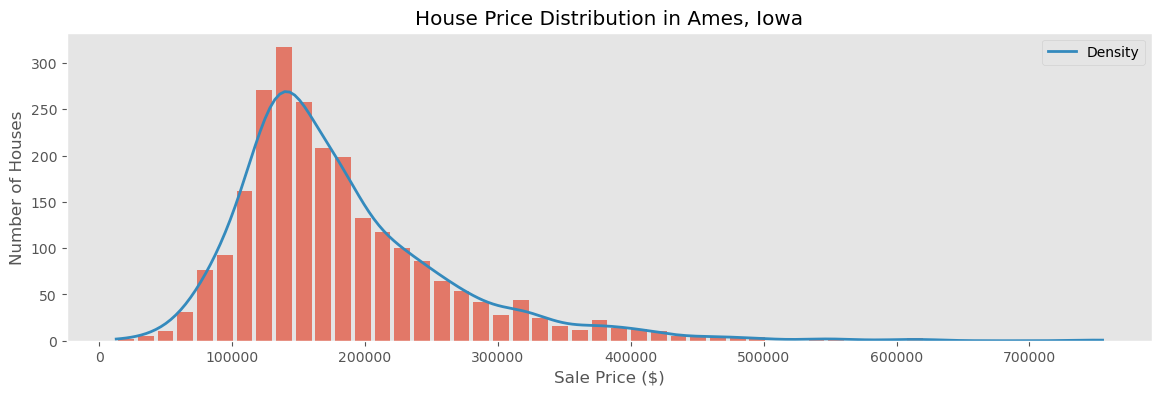

In [571]:
# Analyze house price distribution
print('Price Range:')
print('- Minimum: ${:,.0f}'.format(train.saleprice.min()))
print('- Maximum: ${:,.0f}'.format(train.saleprice.max()))
print('\nKey Statistics:')
print('- Mean: ${:,.0f}'.format(train.saleprice.mean()))
print('- Median: ${:,.0f}'.format(train.saleprice.median()))
print('- Standard Deviation: ${:,.0f}'.format(train.saleprice.std()))

# Show price range distribution
price_ranges = pd.cut(train.saleprice, 
                     bins=[0, 100000, 200000, 300000, 400000, float('inf')],
                     labels=['<$100k', '$100k-$200k', '$200k-$300k', '$300k-$400k', '>$400k'])
print('\nPrice Range Distribution (%):')
print(price_ranges.value_counts(normalize=True).mul(100).round(1).sort_index().to_string())

# Create histogram with density curve
plt.figure(figsize=(14,4))
plt.hist(train.saleprice, bins=50, rwidth=.8, alpha=0.7)
density = gaussian_kde(train.saleprice)
xs = np.linspace(train.saleprice.min(), train.saleprice.max(), 200)
density_scaled = density(xs) * len(train.saleprice) * (train.saleprice.max() - train.saleprice.min())/50
plt.plot(xs, density_scaled, linewidth=2, label='Density')
plt.title('House Price Distribution in Ames, Iowa')
plt.xlabel('Sale Price ($)')
plt.ylabel('Number of Houses')
plt.legend()
plt.grid(False)
plt.show()


Available columns:
['order', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_

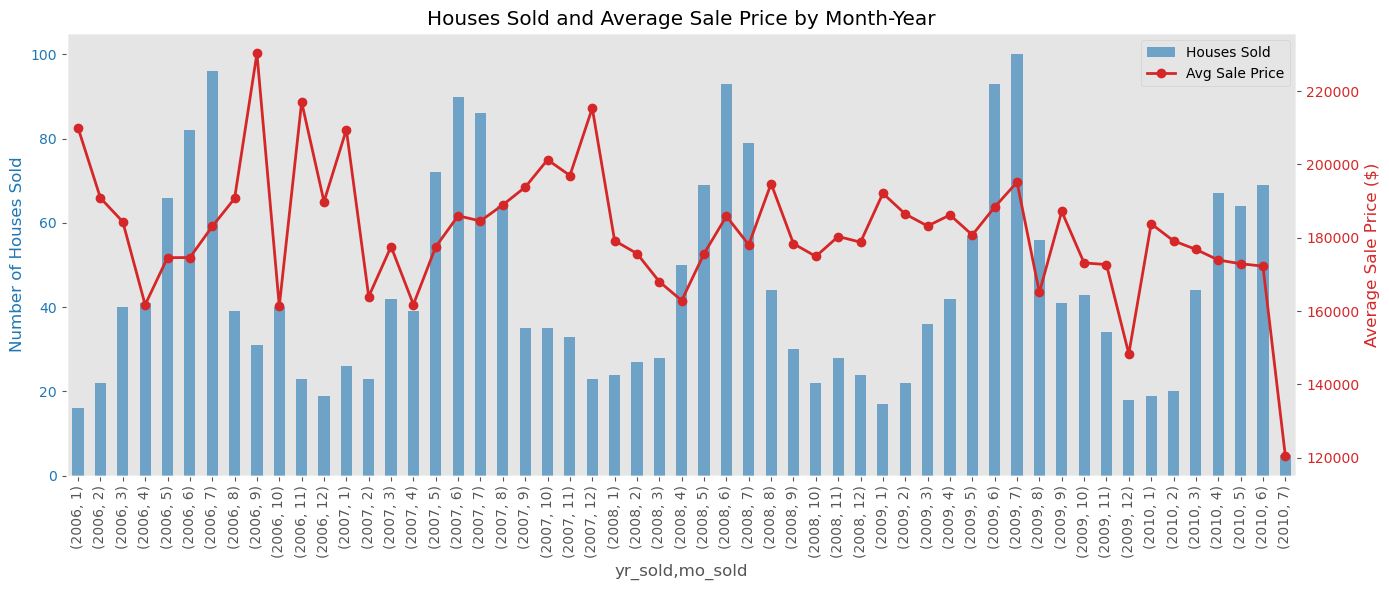

In [570]:
# The error shows 'yrsold' column doesn't exist
# Let's check the actual column names in the dataframe
print("Available columns:")
print(train.columns.tolist())

# The correct column names are likely 'yr_sold' and 'mo_sold'
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the count of houses sold
color = 'tab:blue'
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Number of Houses Sold', color=color)
house_count = train.groupby(['yr_sold', 'mo_sold']).pid.count()
house_count.plot(kind='bar', ax=ax1, color=color, alpha=0.6, label='Houses Sold')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the average sale price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Sale Price ($)', color=color)
avg_price = train.groupby(['yr_sold', 'mo_sold']).saleprice.mean()
avg_price.plot(ax=ax2, color=color, marker='o', linestyle='-', linewidth=2, label='Avg Sale Price')
ax2.tick_params(axis='y', labelcolor=color)

# Add titles and legends
plt.title('Houses Sold and Average Sale Price by Month-Year')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Remove grid
ax1.grid(False)
ax2.grid(False)

plt.show()

# Pool missing values